In [5]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
!which python

/Users/ziru/miniforge3/envs/gesture_input/bin/python


### Preprocessing

In [7]:
# load data
data_folder = Path("/Users/ziru/Documents/GitHub/CMIS_1/P2-gesture-interaction/data")

data = {}

for gesture_file in data_folder.glob("*.csv"):
    gesture_name = gesture_file.stem
    data[gesture_name] = pd.read_csv(gesture_file)

# gesture classes
print(data.keys())

dict_keys(['t', 'f', 'n'])


In [8]:
# look at data from one gesture
data["n"]

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,timestamp
0,0.001500,0.000000,0.123125,0.000061,0.000031,-0.000031,1.741845e+09
1,0.001500,0.000000,0.123375,0.000061,0.000015,-0.000046,1.741845e+09
2,0.001500,-0.000125,0.123250,0.000061,0.000015,-0.000061,1.741845e+09
3,0.001375,-0.000125,0.123250,0.000046,0.000031,-0.000061,1.741845e+09
4,0.001000,0.000375,0.123500,0.000046,0.000031,-0.000061,1.741845e+09
...,...,...,...,...,...,...,...
4538,0.001500,-0.000000,0.123250,0.000031,0.000015,-0.000061,1.741845e+09
4539,0.001500,0.000125,0.123375,0.000031,0.000015,-0.000061,1.741845e+09
4540,0.001500,0.000125,0.123125,0.000031,0.000015,-0.000046,1.741845e+09
4541,0.001500,0.000125,0.123250,0.000046,0.000015,-0.000046,1.741845e+09


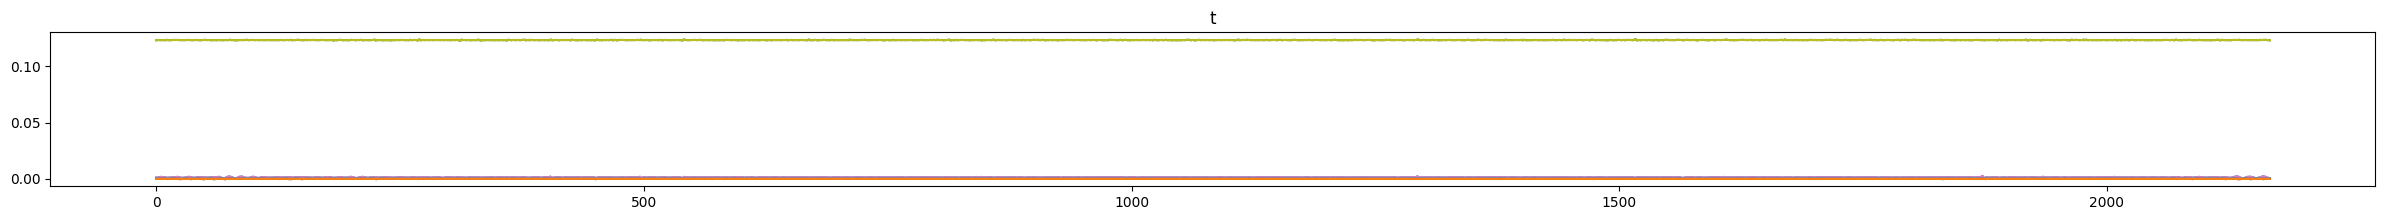

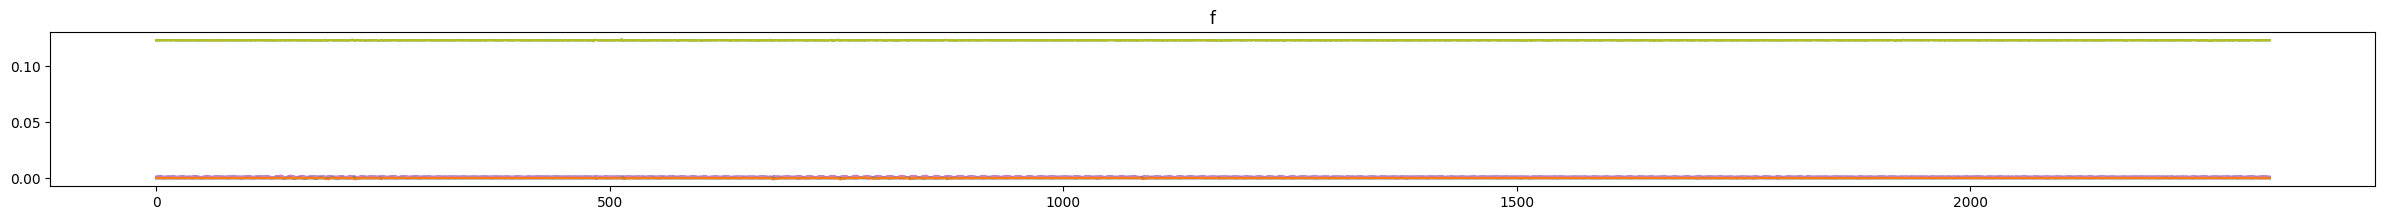

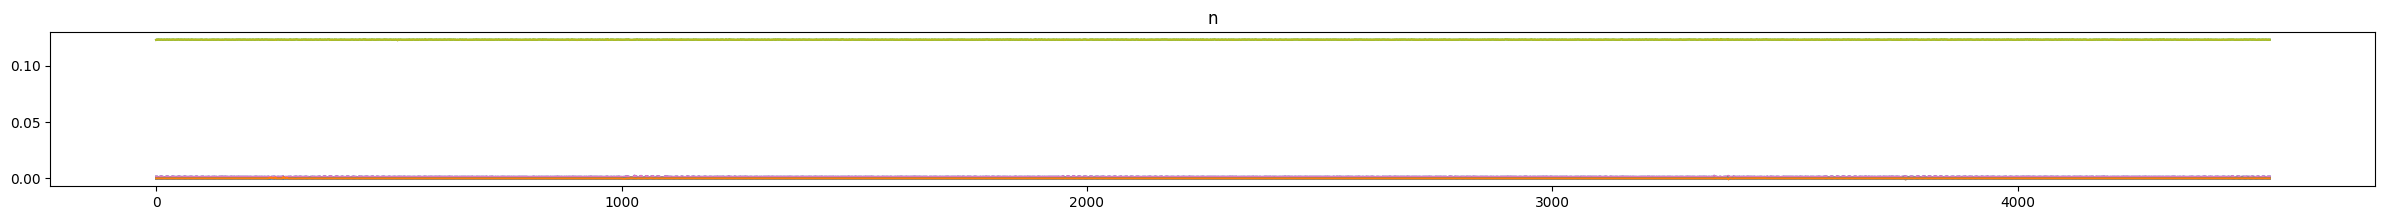

In [9]:
# visualize data from all gestures
for gesture_name, df in data.items():
    plt.figure(figsize=(30, 2))
    plt.title(gesture_name)
    plt.plot(df.values[:, :-1])
    plt.plot(df.values[:, :-1])
    plt.show()




### Training

In [10]:
# create windows of data, window size 50, overlap 49
window_size = 50
X = []
y = []
for gesture_name, df in data.items():
    df_values = df.values[:, :-1]
    label = gesture_name
    for i in range(0, len(df) - window_size, 1):
        X.append(df_values[i:i+window_size].flatten())
        y.append(label)
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)


(8892, 300) (8892,)


In [11]:
# split data into train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7113, 300) (1779, 300) (7113,) (1779,)


1. 输入层
`Input(shape=(6 * window_size,))`

- 输入形状: (6 * window_size,)，例如 (300,)（假设 window_size=50，6 个 IMU 特征）。

- 作用: 接收展平后的滑动窗口数据（每个窗口包含 50 个时间步 × 6 个传感器维度 = 300 个特征）。

2. 全连接隐藏层
`Dense(64, activation='relu')`

- 神经元数量: 64

- 激活函数: ReLU（修正线性单元），引入非线性，帮助模型学习复杂模式。

- 参数数量: (300 + 1) * 64 = 19,264（300 输入特征，64 个神经元，每个神经元有 1 个偏置项）。

3. 输出层
`Dense(len(data.keys()), activation='softmax')`

- 神经元数量: 等于手势类别数（例如 data.keys() 返回 ['wave', 'circle', 'swipe']，则神经元数为 3）。

- 激活函数: Softmax，将输出转换为概率分布（所有类别的概率之和为 1）。

- 参数数量: (64 + 1) * num_classes（例如 3 类时有 (64+1)*3=195 个参数）。

1. 优化器 (Optimizer)  优化器 (Optimizer)
Adam(learning_rate=3e-4):

自适应学习率的优化算法，结合了动量（Momentum）和 RMSProp 的优点。

learning_rate=3e-4 是初始学习率，较小的值适合精细调整权重。

2. 损失函数 (Loss)
SparseCategoricalCrossentropy():

适用于多分类任务，且标签为整数形式（例如 0, 1, 2）。

如果是 one-hot 编码标签，应使用 CategoricalCrossentropy。

3. 评估指标 (Metrics)
SparseCategoricalAccuracy(name='accuracy'):

计算分类准确率，正确预测的样本比例。

同样适用于整数标签。

模型改进思路
调整网络结构:

增加更多隐藏层（如取消注释的 Dense(64, activation='relu')）。

添加 Dropout 层防止过拟合：

python
keras.layers.Dropout(0.5)
优化超参数:

调整学习率（如 1e-3 或 1e-4）。

使用学习率调度（如 ReduceLROnPlateau）。

数据增强:

对 IMU 数据进行随机扰动（如添加噪声、时间偏移）以增强鲁棒性。

In [12]:
# train a keras model
import keras

# 设置模型结构
model = keras.Sequential([
    keras.layers.Input(shape=(6 * window_size,)),  # 输入层
    keras.layers.Dense(64, activation='relu'),     # 全连接隐藏层
    keras.layers.Dense(len(data.keys()), activation='softmax')  # 输出层
])

print(model.summary())

# 编译模型
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),  # 选择 Adam 优化器，学习率 3e-4
    loss=keras.losses.SparseCategoricalCrossentropy(),   # 交叉熵损失函数（用于分类任务）
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')]  # 评估指标（准确率）
)


2025-03-13 01:47:20.086093: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-13 01:47:20.086299: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-13 01:47:20.086316: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1741844840.086801 13390128 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1741844840.087097 13390128 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,459 (76.01 KB)

 Trainable params: 19,459 (76.01 KB)

 Non-trainable params: 0 (0.00 B)

None


👉 callbacks 是训练过程中的“自动助手”，可以自动执行任务，比如保存模型、提前停止训练、调整学习率等。
👉 ModelCheckpoint 可以在每个 epoch 结束后保存模型，防止意外丢失训练进度。
👉 EarlyStopping 监控 val_loss，如果 2 轮不下降就停止训练，避免过拟合。

Epoch 1/10


2025-03-13 01:47:20.630543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4360 - loss: 1.0675 - val_accuracy: 0.5258 - val_loss: 1.0218
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5052 - loss: 1.0357 - val_accuracy: 0.5258 - val_loss: 1.0211
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5073 - loss: 1.0346 - val_accuracy: 0.5258 - val_loss: 1.0224
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4985 - loss: 1.0404 - val_accuracy: 0.5258 - val_loss: 1.0215


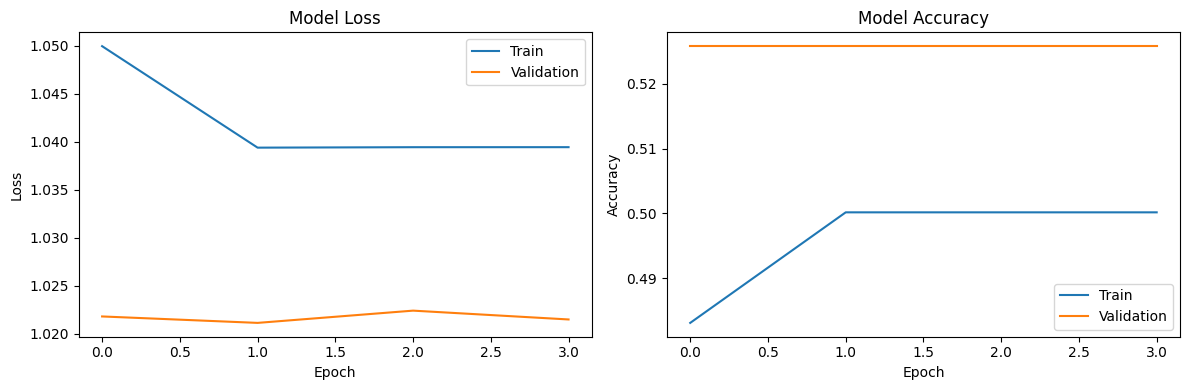

In [13]:
batch_size = 32 # 一次训练用多少数据
epochs = 10 # 数据集被遍历多少次

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_at_epoch_{epoch}.keras"),# 每轮保存模型
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),# 防止过拟合的有效措施（当验证损失连续2轮未改善时终止训练）
]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15, #自动保留15%训练数据作为验证集，用于监控模型泛化能力；
    callbacks=callbacks,
)

score = model.evaluate(X_test, y_test, verbose=0)# 静默模式评估测试集

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

### Evaluation

In [14]:
print(f"Test loss: {score[0]:.4f}", f"Test accuracy: {score[1]:.4f}")

Test loss: 1.0333 Test accuracy: 0.5104


In [15]:
'_'.join(sorted(data.keys()))

'f_n_t'

### Saving

In [16]:
# save the model
import pickle
import time

# make the model name based on the gesture names
run_timestamp = str(time.time()).replace(".", "-")
model_name = '_'.join(sorted(data.keys())) + "__" + run_timestamp

# make a model directory
model_dir = Path('./models')
model_dir.mkdir(parents=True, exist_ok=True)

with open(model_dir / f'{model_name}.keras', 'wb') as f:
    pickle.dump(model, f)
with open(model_dir / f'label_encoder_{model_name}.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [17]:
model_name

'f_n_t__1741844850-225251'

In [18]:
model.predict(X_test[[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[0.2643526 , 0.49773437, 0.23791315]], dtype=float32)

In [19]:
X_test.shape

(1779, 300)